In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore") # suppress the annpoying yfinance deprecation warnings

# Adding the root folder to sys path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from src.data.loaders import YFinanceLoader
from src.data.processing import DataProcessor
from src.data.metrics import FinancialMetrics
from src.index import IndexBuilder
from src.portfolio import PortfolioOptimizer
from src.util import AssignmentConfig, calculate_ols_alpha_beta
from src.model.asset_pricing import AssetPricingModel

In [4]:
default_config = AssignmentConfig()

In [5]:
loader = YFinanceLoader()
df_olhcv = loader.get_daily_ohlcv(default_config.stock_list + [default_config.benchmark_index], "2015-01-01", "2024-12-31")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
df_olhcv.Symbol.unique()

array(['VTRS', 'AAPL', 'GOOG', 'META', 'WMT', '^GSPC'], dtype=object)

In [7]:
df_olhcv

,Date,Close,High,Low,Open,Volume,Symbol
0,2015-01-02,46.595829,47.397923,46.356030,46.752942,1398000,VTRS
1,2015-01-05,46.074875,46.537937,45.835073,46.405633,2996200,VTRS
2,2015-01-06,44.801441,46.992727,44.462412,46.480047,6610900,VTRS
3,2015-01-07,46.397373,46.595827,44.512042,45.247982,3663000,VTRS
4,2015-01-08,46.843899,47.373114,46.595826,46.868705,3164000,VTRS
...,...,...,...,...,...,...,...
2510,2024-12-23,5974.069824,5978.250000,5902.569824,5940.250000,3593280000,^GSPC
2511,2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,^GSPC
2512,2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,^GSPC
2513,2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3159610000,^GSPC


Just to show that they all have market cap >= 10 billion

In [8]:
loader.get_stock_info(default_config.stock_list ,["marketCap"])

,marketCap,symbol
0,11343935488,VTRS
1,3797735702528,AAPL
2,3065787187200,GOOG
3,1925556469760,META
4,810759225344,WMT


In [9]:
data_processor = DataProcessor(input_olhcv_data=df_olhcv, normalize_method="rebasing")
df_olhcv_processed = data_processor.process_data()

In [10]:
df_olhcv_processed.head()

,Date,Close,High,Low,Open,Volume,Symbol,Return,Close_normalized
0,2015-01-02,24.261051,24.729274,23.821675,24.718178,212818400,AAPL,NaN,1.000000
1,2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000,AAPL,-0.028172,0.971828
2,2015-01-06,23.579792,23.839422,23.218083,23.641926,263188400,AAPL,0.000094,0.971920
3,2015-01-07,23.910437,24.010294,23.677434,23.788387,160423600,AAPL,0.014022,0.985548
4,2015-01-08,24.829128,24.886824,24.121246,24.238858,237458000,AAPL,0.038422,1.023415


When we groupby each symbol, the first value of `return` will always be `NaN` and the first `Close_normalized` will always be 1

In [11]:
df_olhcv_processed.groupby("Symbol").head(2)

,Date,Close,High,Low,Open,Volume,Symbol,Return,Close_normalized
0,2015-01-02,24.261051,24.729274,23.821675,24.718178,212818400,AAPL,NaN,1.000000
1,2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000,AAPL,-0.028172,0.971828
2515,2015-01-02,25.990791,26.310719,25.955630,26.198793,28951268,GOOG,NaN,1.000000
2516,2015-01-05,25.448997,25.967021,25.408884,25.914029,41196796,GOOG,-0.020846,0.979154
5030,2015-01-02,77.969353,78.446415,77.223948,78.098561,18177500,META,NaN,1.000000
5031,2015-01-05,76.717064,78.764440,76.389084,77.502225,26452200,META,-0.016061,0.983939
7545,2015-01-02,46.595829,47.397923,46.356030,46.752942,1398000,VTRS,NaN,1.000000
7546,2015-01-05,46.074875,46.537937,45.835073,46.405633,2996200,VTRS,-0.011180,0.988820
10060,2015-01-02,23.266569,23.488672,23.171769,23.366786,13505400,WMT,NaN,1.000000
10061,2015-01-05,23.198851,23.380324,23.160930,23.217812,20937000,WMT,-0.002911,0.997089


Plotting normalized closing price

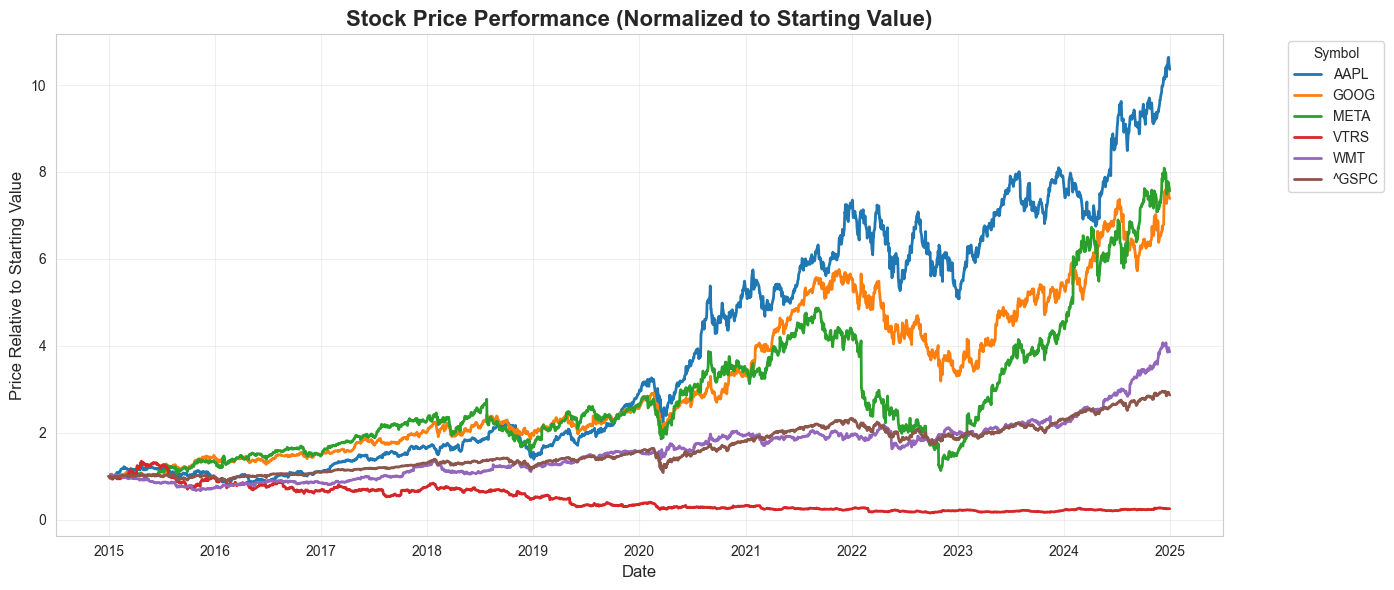

In [12]:
# TODO: refactor this into a function
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))


sns.lineplot(data=df_olhcv_processed, 
             x='Date', 
             y='Close_normalized', 
             hue='Symbol',
             linewidth=2)


plt.title('Stock Price Performance (Normalized to Starting Value)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price Relative to Starting Value', fontsize=12)
plt.legend(title='Symbol', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Annualized Return & Volatility

In [13]:
for symbol in df_olhcv_processed['Symbol'].unique():
    df_symbol = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == symbol,"Close_normalized"].pct_change().dropna()
    financial_metrics = FinancialMetrics(df_symbol)
    annualized_return_arith = financial_metrics.annualized_return(method="arithmetic")
    annualized_return_geom = financial_metrics.annualized_return(method="geometric")
    annualized_volatility = financial_metrics.annualized_volatility()
    
    print("================================")
    print(f"Symbol: {symbol}")
    print(f"  Annualized Return (Arithmetic): {annualized_return_arith:.2%}")
    print(f"  Annualized Return (Geometric): {annualized_return_geom:.2%}")
    print(f"  Annualized Volatility: {annualized_volatility:.2%}")
    print()

Symbol: AAPL
  Annualized Return (Arithmetic): 27.50%
  Annualized Return (Geometric): 26.41%
  Annualized Volatility: 28.46%

Symbol: GOOG
  Annualized Return (Arithmetic): 24.11%
  Annualized Return (Geometric): 22.20%
  Annualized Volatility: 28.50%

Symbol: META
  Annualized Return (Arithmetic): 27.40%
  Annualized Return (Geometric): 22.49%
  Annualized Volatility: 37.49%

Symbol: VTRS
  Annualized Return (Arithmetic): -6.36%
  Annualized Return (Geometric): -12.77%
  Annualized Volatility: 37.94%

Symbol: WMT
  Annualized Return (Arithmetic): 15.78%
  Annualized Return (Geometric): 14.51%
  Annualized Volatility: 21.13%

Symbol: ^GSPC
  Annualized Return (Arithmetic): 12.17%
  Annualized Return (Geometric): 11.15%
  Annualized Volatility: 17.83%



In [14]:
df_exclude_sp = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] != '^GSPC'].reset_index(drop=True)

index_builder = IndexBuilder(input_data=df_exclude_sp)
df_equal_weighted_index = index_builder.build_equal_weighted_index(base_value=1.0) # base value is an optional parameter
df_price_weighted_index = index_builder.build_price_weighted_index()

In [15]:
index_df_combined = (
    df_equal_weighted_index.merge(
        df_price_weighted_index, on="Date", how="inner"
    )
    .merge(
        df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == '^GSPC', ['Date', 'Close_normalized']],
        on="Date",
        how="inner"
    )
    .rename(columns={"Close_normalized": "SP_500"})
    .dropna()
    .reset_index(drop=True)
)

In [16]:
index_df_combined.tail()

,Date,Equal_Weighted_Index,Price_Weighted_Index,SP_500
2509,2024-12-23,4.695059,5.957759,2.902570
2510,2024-12-24,4.743223,6.033671,2.934623
2511,2024-12-26,4.750478,6.027141,2.933432
2512,2024-12-27,4.699949,5.956464,2.901001
2513,2024-12-30,4.648802,5.886617,2.869954


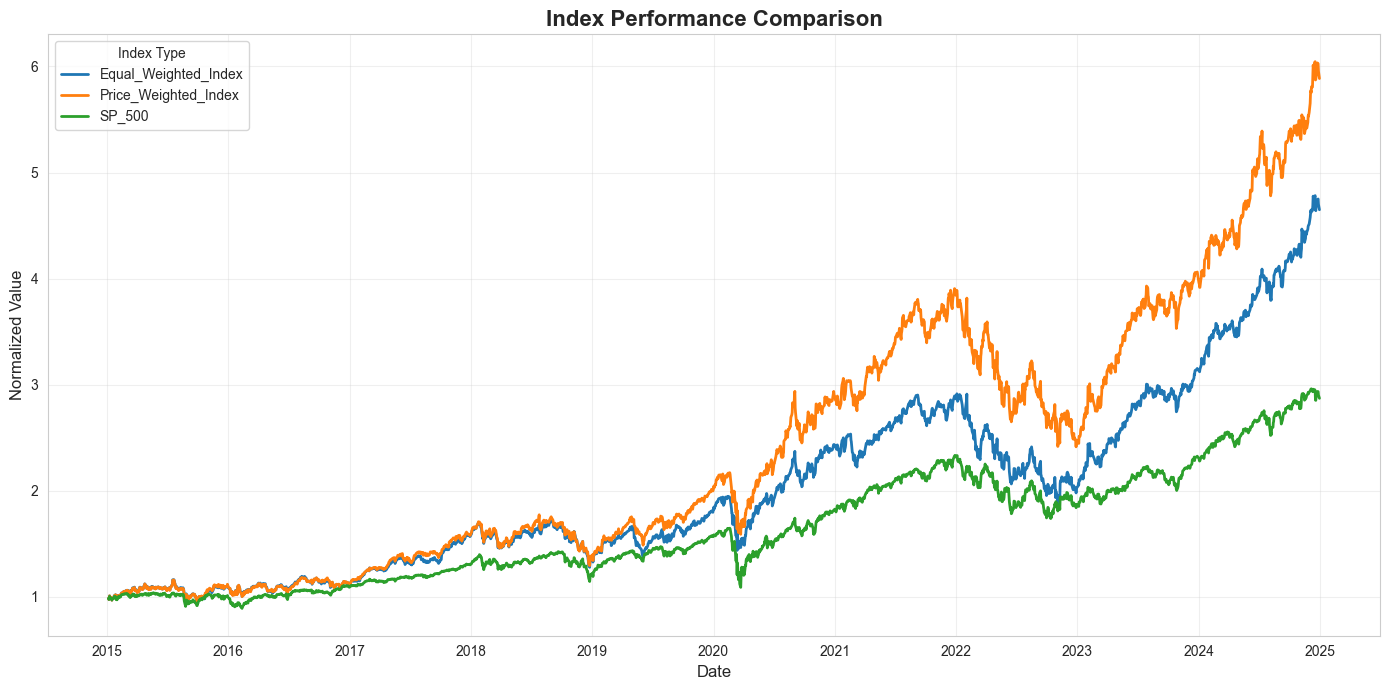

In [17]:
# TODO: refactor 
df_plot = index_df_combined.melt(id_vars=['Date'], 
                                 value_vars=['Equal_Weighted_Index', 'Price_Weighted_Index', 'SP_500'],
                                 var_name='Index', 
                                 value_name='Value')

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))


sns.lineplot(data=df_plot, 
             x='Date', 
             y='Value', 
             hue='Index',
             linewidth=2)


plt.title('Index Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(title='Index Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
for col in [i for i in index_df_combined.columns if i != "Date"]:
    series = index_df_combined[col].pct_change().dropna()
    financial_metrics = FinancialMetrics(series)
    annualized_return_geom = financial_metrics.annualized_return(method="geometric")
    annualized_return_arith = financial_metrics.annualized_return(method="arithmetic")
    annualized_volatility = financial_metrics.annualized_volatility()
    print("================================")
    print(f"Index: {col}")
    print(f"  Annualized Return (Arithmetic): {annualized_return_arith:.2%}")
    print(f"  Annualized Return (Geometric): {annualized_return_geom:.2%}")
    print(f"  Annualized Volatility: {annualized_volatility:.2%}")
    print()

Index: Equal_Weighted_Index
  Annualized Return (Arithmetic): 17.85%
  Annualized Return (Geometric): 16.85%
  Annualized Volatility: 21.33%

Index: Price_Weighted_Index
  Annualized Return (Arithmetic): 20.62%
  Annualized Return (Geometric): 19.65%
  Annualized Volatility: 23.10%

Index: SP_500
  Annualized Return (Arithmetic): 12.35%
  Annualized Return (Geometric): 11.36%
  Annualized Volatility: 17.82%



Market Portfolio A:
Portfolio constructed using the 3 stocks that come from the same sector and have positive returns for the past 10 years

In [19]:
df_subset = df_olhcv_processed.loc[df_olhcv_processed['Symbol'].isin(['AAPL', 'GOOG', 'META'])]

In [20]:
portfolio_optimizer = PortfolioOptimizer(input_data=df_subset, risk_free_rate=0.04, iterations=10000)

results, max_sharpe_portfolio, min_volatility_portfolio = portfolio_optimizer.monte_carlo_optimization()

In [22]:
results.sort_values(by='Sharpe Ratio', ascending=False).head()

,Return,Volatility,Sharpe Ratio,Weight_AAPL,Weight_GOOG,Weight_META
9915,0.265834,0.258498,0.873642,0.615692,0.265864,0.118443
7160,0.265709,0.258358,0.873632,0.611527,0.269536,0.118937
2926,0.265695,0.258345,0.873616,0.615872,0.270112,0.114016
1551,0.265567,0.258203,0.873602,0.606164,0.273704,0.120133
9731,0.266051,0.258758,0.873601,0.625663,0.259577,0.114760


In [23]:
max_sharpe_portfolio

Return          0.265834
Volatility      0.258498
Sharpe Ratio    0.873642
Weight_AAPL     0.615692
Weight_GOOG     0.265864
Weight_META     0.118443
Name: 9915, dtype: float64

In [24]:
min_volatility_portfolio

Return          0.258862
Volatility      0.254606
Sharpe Ratio    0.859609
Weight_AAPL     0.483626
Weight_GOOG     0.473736
Weight_META     0.042638
Name: 6126, dtype: float64

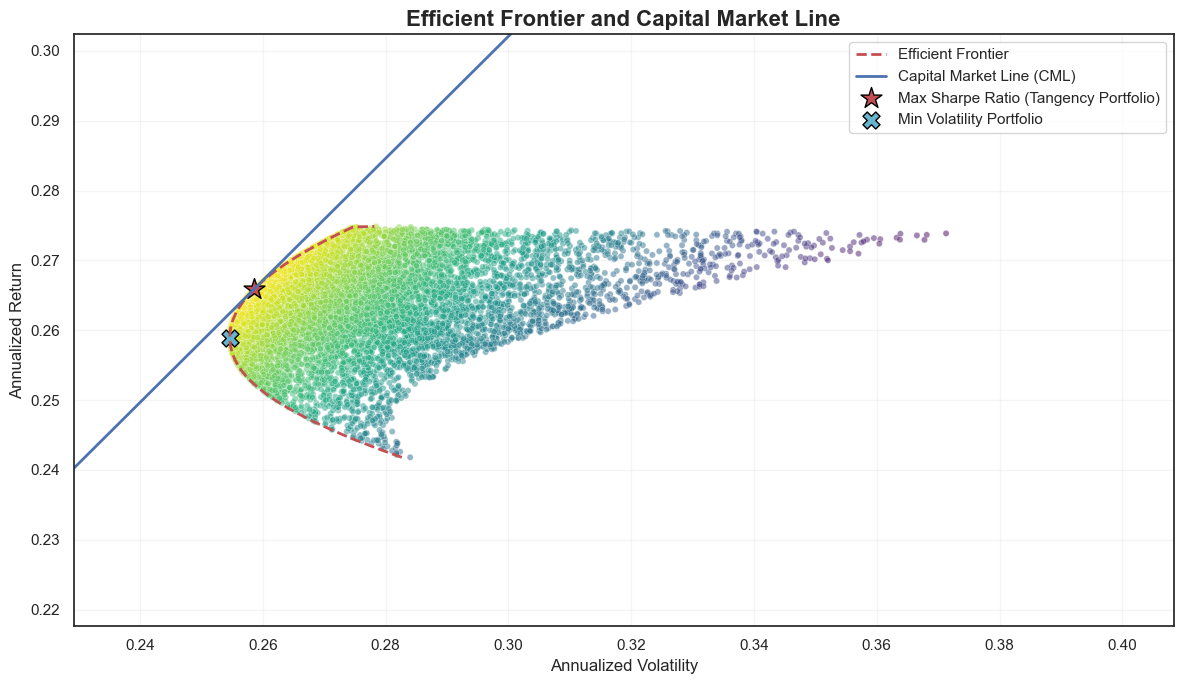

In [25]:
# TODO: refactor

# Calculate the efficient frontier
efficient_frontier = portfolio_optimizer.calculate_efficient_frontier(results, 1000)

risk_free_rate = portfolio_optimizer.risk_free_rate
max_sharpe_vol = max_sharpe_portfolio['Volatility']
max_sharpe_ret = max_sharpe_portfolio['Return']

# Calculate the slope of the CML (which is the Sharpe Ratio)
cml_slope = (max_sharpe_ret - risk_free_rate) / max_sharpe_vol


cml_x = [0, results['Volatility'].max() * 1.1]

cml_y = [risk_free_rate, risk_free_rate + cml_slope * cml_x[1]]


sns.set_theme(style="white")
plt.figure(figsize=(12, 7))

# Plot the Monte Carlo simulation results
sns.scatterplot(
    data=results,
    x='Volatility',
    y='Return',
    hue='Sharpe Ratio',
    palette='viridis',
    s=20,
    alpha=0.5,
    legend=False
)

# Plot the Efficient Frontier
plt.plot(efficient_frontier['Volatility'], efficient_frontier['Return'], 'r--', linewidth=2, label='Efficient Frontier')

# Plot the CML
plt.plot(cml_x, cml_y, 'b-', linewidth=2, label='Capital Market Line (CML)')

# Highlight the max Sharpe ratio portfolio
plt.scatter(
    max_sharpe_portfolio['Volatility'],
    max_sharpe_portfolio['Return'],
    color='r',
    marker='*',
    s=250,
    edgecolors='black',
    label='Max Sharpe Ratio (Tangency Portfolio)'
)

# Highlight the min volatility portfolio
plt.scatter(
    min_volatility_portfolio['Volatility'],
    min_volatility_portfolio['Return'],
    color='c',
    marker='X',
    s=150,
    edgecolors='black',
    label='Min Volatility Portfolio'
)


plt.title('Efficient Frontier and Capital Market Line', fontsize=16, fontweight='bold')
plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.xlim(results['Volatility'].min() * 0.9, results['Volatility'].max() * 1.1)
plt.ylim(results['Return'].min() * 0.9, results['Return'].max() * 1.1)
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

In [44]:
optimal_weights = max_sharpe_portfolio.filter(like="Weight_")
portfolio_return = pd.Series(
    np.dot(portfolio_optimizer.returns, optimal_weights), 
)

In [45]:
market_return = df_olhcv_processed.loc[df_olhcv_processed['Symbol'] == '^GSPC',"Return"].dropna().reset_index(drop=True)

In [46]:
df_returns = pd.DataFrame({
    "Portfolio": portfolio_return,
    "Market": market_return
})

In [50]:
daily_adjusted_risk_free_rate = 0.04 / 252 

df_returns['Portfolio_Excess_Return'] = df_returns['Portfolio'] - daily_adjusted_risk_free_rate
df_returns['Market_Excess_Return'] = df_returns['Market'] - daily_adjusted_risk_free_rate

In [51]:
beta, alpha, r_value, p_value, std_err = stats.linregress(
    df_returns['Market_Excess_Return'],
    df_returns['Portfolio_Excess_Return']
)


print(f"Calculated Beta (β): {beta:.4f}")
print(f"Calculated Alpha (α): {alpha:.4f}")
print(f"Goodness of Fit (R²): {r_value**2:.4f}")

annualized_alpha = alpha * 252 
print(f"Annualized Alpha: {annualized_alpha:.4f}")

Calculated Beta (β): 1.1898
Calculated Alpha (α): 0.0005
Goodness of Fit (R²): 0.6735
Annualized Alpha: 0.1287


Market Portfolio B:
Using all 5 stocks

In [52]:
df_all_stocks = df_olhcv_processed.loc[df_olhcv_processed['Symbol'].isin(default_config.stock_list)]

In [55]:
portfolio_optimizer = PortfolioOptimizer(input_data=df_all_stocks, risk_free_rate=0.04, iterations=10000)

results, max_sharpe_portfolio, min_volatility_portfolio = portfolio_optimizer.monte_carlo_optimization()

In [56]:
results.sort_values(by='Sharpe Ratio', ascending=False).head()

,Return,Volatility,Sharpe Ratio,Weight_AAPL,Weight_GOOG,Weight_META,Weight_VTRS,Weight_WMT
3068,0.227685,0.204719,0.916790,0.336876,0.187866,0.130124,0.001612,0.343521
5372,0.227287,0.204355,0.916480,0.318829,0.246829,0.099774,0.000102,0.334466
7793,0.226957,0.204039,0.916280,0.371026,0.235106,0.057738,0.002741,0.333389
7485,0.237095,0.215170,0.915995,0.416545,0.226377,0.102600,0.001293,0.253186
4733,0.231332,0.209698,0.912416,0.376843,0.227404,0.101930,0.006354,0.287469


In [57]:
optimal_weights = max_sharpe_portfolio.filter(like="Weight_")
portfolio_return = pd.Series(
    np.dot(portfolio_optimizer.returns, optimal_weights), 
)

df_returns = pd.DataFrame({
    "Portfolio": portfolio_return,
    "Market": market_return
})

daily_adjusted_risk_free_rate = 0.04 / 252 

df_returns['Portfolio_Excess_Return'] = df_returns['Portfolio'] - daily_adjusted_risk_free_rate
df_returns['Market_Excess_Return'] = df_returns['Market'] - daily_adjusted_risk_free_rate


beta, alpha, r_value, p_value, std_err = stats.linregress(
    df_returns['Market_Excess_Return'],
    df_returns['Portfolio_Excess_Return']
)


print(f"Calculated Beta (β): {beta:.4f}")
print(f"Calculated Alpha (α): {alpha:.4f}")
print(f"Goodness of Fit (R²): {r_value**2:.4f}")

annualized_alpha = alpha * 252 
print(f"Annualized Alpha: {annualized_alpha:.4f}")

Calculated Beta (β): 0.9598
Calculated Alpha (α): 0.0004
Goodness of Fit (R²): 0.6989
Annualized Alpha: 0.1093
